This is a notebook that will quickly walk through the calculations needed to determine the exposure time to a given stellar population feature, such as the Tip of the Red Giant Branch (TRGB), the Horizontal Branch (HB, or Red Clump), or the Main Sequence Turn-Off (MSTO).

In [1]:
# all we need is numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# These are just preferences for making plots
# If you are getting errors from matplotlib, feel free to comment this out
plt.rc('font', **{'size': 8, 'sans-serif': ['Helvetica'], 'family': 'sans-serif'})
plt.rc('legend',**{'fontsize':6})                                             
plt.rc("text.latex", preamble=[
    "\\usepackage[T1]{fontenc}\\usepackage{amsmath}"])
plt.rc("text", usetex=True)
plt.rc('ps', usedistiller='xpdf')
plt.rc('savefig', **{'dpi': 300})

Like the other notebooks, we begin by defining a lot of the same variables.

In [3]:
# First setting the range of metallicities and ages that are covered, these are our default values
metlist = np.array([0.5,0.25,0.0,-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0,-2.25,-2.5,-2.75,-3.,-3.25])
agelist = np.array([8.95,9.,9.05,9.1,9.15,9.2,9.25,9.3,9.35,9.4,9.45,9.5,9.55,9.6,9.65,9.7,9.75,9.8,9.85,9.9,9.95,10.,10.05,10.1])
nmet  = len(metlist)
nage  = len(agelist)

# for MIST
nfilt = 7
filter_names = np.array([r"$F062/R$",r"$F087/Z$",r"$F106/Y$",r"$F129/J$",r"$F146/W$",r"$F158/H$",r"$F184$"])
# filter indexes to be used below
filter_index_dict = {"F062/R":9,"F087/Z":10,"F106/Y":11,"F129/J":12,"F146/W":13,"F158/H":14,"F184":15}
# 5-sigma point source detection limit for 10^3 sec exposure in each band
ps_detect_5slim = np.array([27.8, 27.5, 27.4, 27.3, 27.6, 27.3, 26.8])
path_to_isos = "../mist_isos"

We first will define a function that will tell us the brightest object in a given Equivalent Evolutionary Phase (EEP). This is a term used by the MIST Isochrone team to determine a certain phase of stellar evolution, so here we are only using the MIST Isochrones. Unlike our other notebooks, in order to use this function you will have needed to download the MIST Isochrones and put them in `iso_path` which will be given to the function below so that is can load the isochrones. You should make sure that the naming of your isochrone files follows the convention of the files in the function written below.

In [4]:
# This is a function to determine the brightest absolute magnitude
# in a given population feature, determined by the ranges in EEP 
# that are provided, and a given filter, determined by the 
# filter_index variable. This function determines this magnitude for
# each metallicity and age in the mlist and alist provided.
# iso_path tells the function where your isochrones are
def get_absM(mlist,alist,filter_index,eep_low,eep_high,iso_path):
    outM = np.zeros((mlist.shape[0],alist.shape[0]))
    for (i,met) in enumerate(mlist):
        if met>-0.1:
            (eep,age,imass,T,L) = np.loadtxt("%s/mist_fehp%1.2f.iso.cmd"%(iso_path,abs(met)),usecols=[0,1,2,4,6]).T
            M = np.loadtxt("%s/mist_fehp%1.2f.iso.cmd"%(iso_path,abs(met)),usecols=[filter_index]).T
        else:
            (eep,age,imass,T,L) = np.loadtxt("%s/mist_fehm%1.2f.iso.cmd"%(iso_path,abs(met)),usecols=[0,1,2,4,6]).T
            M = np.loadtxt("%s/mist_fehm%1.2f.iso.cmd"%(iso_path,abs(met)),usecols=[filter_index]).T
        for (j,a) in enumerate(alist):

            sids = np.intersect1d(np.where(age>a-0.01),np.where(age<a+0.01))
            feature_ids = np.intersect1d(sids,np.where(np.logical_and(eep>=eep_low,eep<=eep_high)))
            # need to make sure that this feature is actually 
            # apparent at this age and metallicity
            if len(feature_ids)>0:
                outM[i][j] = min(M[feature_ids])
            else:
                outM[i][j] = -1000
    return(outM)

We can apply this function to get, for example, the absolute magnitude of the TRGB over a range of metallicities and ages. In our work, we define the TRGB as $560 \leq {\rm EEP}\leq 580$. Note the use of the pre-defined (above) index dictionary for a given filter. This dictionary may change based on what filters you selected when downloading the MIST isochrones, keep this in mind. Your `path_to_isos` variable should also not necessarily be the same as mine, set above.

Here we will get the absolute magnitude of the TRGB in the $F158/H$ band.

In [5]:
H_trgb = get_absM(metlist,agelist,filter_index_dict["F158/H"],560,580,path_to_isos)

We can the plot our results as a function of metallicity for each age.

Text(0.5, 0, '${\\rm [Fe/H]}$')

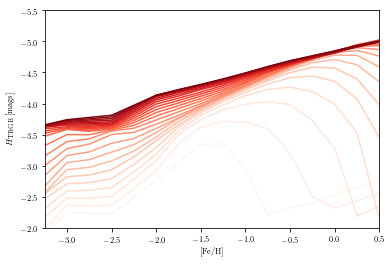

In [18]:
for j in range(nage):
    # make sure we aren't plotting anything without a TRGB
    sids = np.where(H_trgb[:,j] >-900)[0]
    plt.plot(metlist[sids],H_trgb[sids,j],c=plt.cm.Reds((1.*j)/nage))

plt.ylim(-2,-5.5)
plt.xlim(min(metlist),max(metlist))
plt.ylabel(r"$H_{\rm TRGB} \, [{\rm mags}]$")
plt.xlabel(r"${\rm [Fe/H]}$")

Where we can then see that the brightness of the TRGB is relatively insensitive to age (once the population is old enough) but is a rather strong function of metallicity.

If we then imagine that we are looking at a given galaxy and assume a distance, $D$, to this galaxy, we can translate the absolute magnitude given above in to a minimal exposure time needed to detect the population feature. Lets do this next.

In [21]:
# distance to assumed object, in Mpc
Dobs = 4
# distance modulus to observation
mu = 25 + 5*np.log10(Dobs)
texp = 1e3*10**((H_trgb+mu-ps_detect_5slim[5])/1.25)

Text(0.5, 0, '${\\rm [Fe/H]}$')

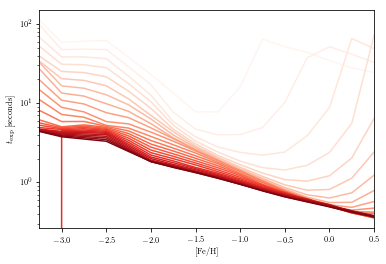

In [22]:
for j in range(nage):
    # make sure we aren't plotting anything without a TRGB
    sids = np.where(H_trgb[:,j] <1e7)[0]
    plt.plot(metlist[sids],texp[sids,j],c=plt.cm.Reds((1.*j)/nage))

#plt.ylim(-2,-5.5)
plt.yscale("log")
plt.xlim(min(metlist),max(metlist))
plt.ylabel(r"$t_{\rm exp} \, [{\rm seconds}]$")
plt.xlabel(r"${\rm [Fe/H]}$")

Okay but really we acer about whether or not, for a given population, we can detect a certain feature in certain bands. Let's now calculate the limiting magnitude for several differnt bands. This may take awhile, to load all the files separately, and there is certainly a function that could be written to do this more efficiently, but here we are.

In [23]:
R_trgb = get_absM(metlist,agelist,filter_index_dict["F062/R"],560,580,path_to_isos)
Z_trgb = get_absM(metlist,agelist,filter_index_dict["F087/Z"],560,580,path_to_isos)
Y_trgb = get_absM(metlist,agelist,filter_index_dict["F106/Y"],560,580,path_to_isos)
J_trgb = get_absM(metlist,agelist,filter_index_dict["F129/J"],560,580,path_to_isos)
W_trgb = get_absM(metlist,agelist,filter_index_dict["F146/W"],560,580,path_to_isos)
F_trgb = get_absM(metlist,agelist,filter_index_dict["F184"],560,580,path_to_isos)

Text(0, 0.5, '$t_{\\rm exp}\\, [{\\rm seconds}]$')

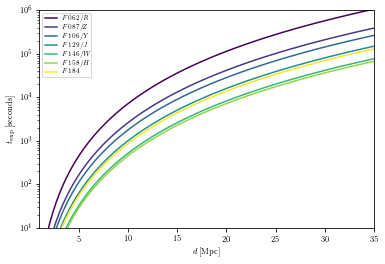

In [39]:
# Then we can pick a given metallicity and age
meti = 10 # [Fe/H] = -2
agej = 21 # age = 10 Gyr

# we'll plot the exposure time for a range of assumed 
drange = np.linspace(1,35,100)
mu = 25 + 5*np.log10(drange)
texp_Rtrgb = 1e3*10**((1+R_trgb[meti,agej]+mu-ps_detect_5slim[0])/1.25)
texp_Ztrgb = 1e3*10**((1+Z_trgb[meti,agej]+mu-ps_detect_5slim[1])/1.25)
texp_Ytrgb = 1e3*10**((1+Y_trgb[meti,agej]+mu-ps_detect_5slim[2])/1.25)
texp_Jtrgb = 1e3*10**((1+J_trgb[meti,agej]+mu-ps_detect_5slim[3])/1.25)
texp_Wtrgb = 1e3*10**((1+W_trgb[meti,agej]+mu-ps_detect_5slim[4])/1.25)
texp_Htrgb = 1e3*10**((1+H_trgb[meti,agej]+mu-ps_detect_5slim[5])/1.25)
texp_Ftrgb = 1e3*10**((1+F_trgb[meti,agej]+mu-ps_detect_5slim[6])/1.25)


plt.plot(drange,texp_Rtrgb,c=plt.cm.viridis(0./(nfilt-1)),label=filter_names[0])
plt.plot(drange,texp_Ztrgb,c=plt.cm.viridis(1./(nfilt-1)),label=filter_names[1])
plt.plot(drange,texp_Ytrgb,c=plt.cm.viridis(2./(nfilt-1)),label=filter_names[2])
plt.plot(drange,texp_Jtrgb,c=plt.cm.viridis(3./(nfilt-1)),label=filter_names[3])
plt.plot(drange,texp_Wtrgb,c=plt.cm.viridis(4./(nfilt-1)),label=filter_names[4])
plt.plot(drange,texp_Htrgb,c=plt.cm.viridis(5./(nfilt-1)),label=filter_names[5])
plt.plot(drange,texp_Ftrgb,c=plt.cm.viridis(6./(nfilt-1)),label=filter_names[6])

plt.legend()
plt.yscale("log")
plt.xlim(1,35)
plt.ylim(1e1,1e6)
plt.xlabel(r"$d\, [{\rm Mpc}]$")
plt.ylabel(r"$t_{\rm exp}\, [{\rm seconds}]$")

In [40]:
print(np.interp(10,drange,texp_Ytrgb))
print(np.interp(10,drange,texp_Jtrgb))
print(np.interp(10,drange,texp_Htrgb))
print(np.interp(10,drange,texp_Ftrgb))

1777.6743618686896
1000.899814918988
450.6002298729981
866.3971378863896
